# Лабораторная работа №1

## Логистическая регрессия в качестве нейронной сети

В работе предлагается использовать набор данных _notMNIST_, который состоит из изображений размерностью 28×28 первых 10 букв латинского алфавита (_A_ ... _J_, соответственно). Обучающая выборка содержит порядка 500 тыс. изображений, а тестовая – около 19 тыс.

Данные можно скачать по ссылке:

* https://commondatastorage.googleapis.com/books1000/notMNIST_large.tar.gz (большой набор данных);

* https://commondatastorage.googleapis.com/books1000/notMNIST_small.tar.gz (маленький набор данных);

Описание данных на английском языке доступно по ссылке:
http://yaroslavvb.blogspot.sg/2011/09/notmnist-dataset.html

### Задание 1

Загрузите данные и отобразите на экране несколько из изображений с помощью языка Python.

In [0]:
SMALL_DS_URL = 'https://commondatastorage.googleapis.com/books1000/notMNIST_small.tar.gz'
LARGE_DS_URL = 'https://commondatastorage.googleapis.com/books1000/notMNIST_large.tar.gz'

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt

In [0]:
from urllib.request import urlretrieve
import tarfile
import os

def tar_to_dir(_tar_url, _key):

    dir_name_ = 'dataset_' + _key
    local_file_name_ = dir_name_ + '.f'

    urlretrieve(_tar_url, local_file_name_)

    with tarfile.open(local_file_name_, 'r:gz') as tar_:
        tar_.extractall(dir_name_)

    os.remove(local_file_name_)

    return dir_name_

In [0]:
def get_examples(_dataframe, _label_column_name, _data_column_name):

    n_ = _dataframe[_label_column_name].nunique()

    examples_ = _dataframe.sample(n_)[_data_column_name]

    return examples_

In [0]:
from math import ceil
import numpy as np

def print_examples(_examples):

    fig = plt.figure(figsize = (16, 6))

    height_ = 2
    width_ = ceil(_examples.count() / height_)
    
    for i, item_ in enumerate(_examples):

        ax = fig.add_subplot(height_, width_, i + 1)
        ax.axis('off')
        ax.imshow(item_, cmap = 'gray', interpolation = 'none')

    plt.show()

In [0]:
from imageio import imread
import pandas as pd

def image_to_array(_image):  
    try:
        array_ = imread(_image)

        return True, array_
    except:
        return False, None

def get_inner_dir(_dir_path):
    
    return [x[0] for x in os.walk(_dir_path)][1]

def remove_duplicates(_dataframe, _data_column_name):

   return _dataframe.loc[_dataframe[_data_column_name].astype(str).drop_duplicates().index]

def dir_to_dataframe(_dir_path):

    dataframes_ = []

    inner_dir_path_ = get_inner_dir(_dir_path)

    for subdir_ in sorted(os.listdir(inner_dir_path_)):
        
        letter_ = subdir_

        data_ = []

        files_ = os.listdir(os.path.join(inner_dir_path_, subdir_))

        for f in files_:
            file_path_ = os.path.join(inner_dir_path_, subdir_, f)
            
            can_read_, im = image_to_array(file_path_)

            if can_read_:
                data_.append(im)

        g = [letter_] * len(data_)

        e = np.array(data_)

        h = pd.DataFrame()

        h['data'] = data_
        h['label'] = letter_

        dataframes_.append(h)

    result_ = pd.concat(dataframes_, ignore_index = True)

    unique_ = remove_duplicates(result_, 'data')

    return unique_

In [0]:
def tar_to_dataframe(_tar_url, _key):
    
    dir_name_ = tar_to_dir(_tar_url, _key)

    inner_dir_ = get_inner_dir(dir_name_)

    dataframe_ = dir_to_dataframe(dir_name_)

    examples_ = get_examples(dataframe_, 'label', 'data')

    print_examples(examples_)

    return dataframe_

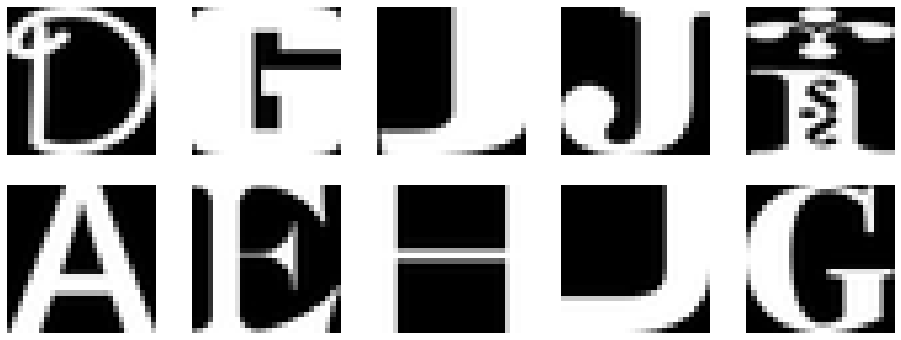

In [0]:
small_dataframe = tar_to_dataframe(SMALL_DS_URL, 'small')

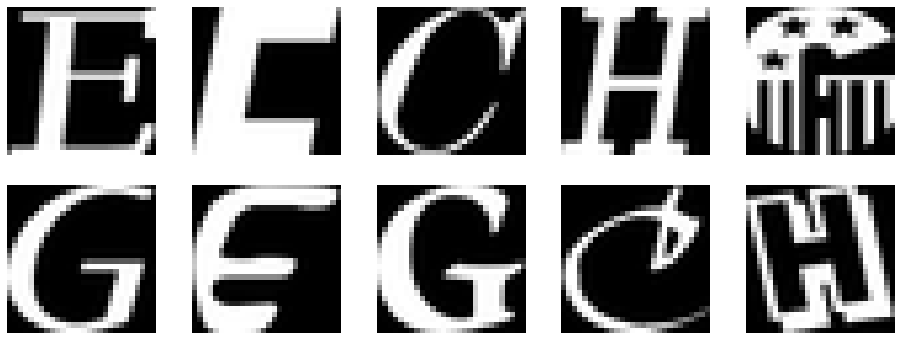

In [0]:
large_dataframe = tar_to_dataframe(LARGE_DS_URL, 'large')

### Задание 2

Проверьте, что классы являются сбалансированными, т.е. количество изображений, принадлежащих каждому из классов, примерно одинаково (в данной задаче 10 классов).

In [0]:
def print_balance(_dataframe, _label_column_name):
    
    values_ = _dataframe[_label_column_name].value_counts().sort_values(ascending = False)

    print(('{:>10}' * len(values_)).format(*values_))

In [0]:
print_balance(small_dataframe, 'label')

      1853      1850      1850      1848      1848      1848      1847      1847      1845      1596


In [0]:
print_balance(large_dataframe, 'label')

     47226     47102     47012     46890     46771     46663     46577     46521     46098     41086


### Задание 3

Разделите данные на три подвыборки: обучающую (200 тыс. изображений), валидационную (10 тыс. изображений) и контрольную (тестовую) (19 тыс. изображений).

In [0]:
def split(_dataframe, _n_train, _n_test, _n_val):

    assert _dataframe.shape[0] >= _n_train + _n_test + _n_val

    to_be_split_ = _dataframe.copy(deep = True)

    seed_ = 666

    train_ = to_be_split_.sample(n = _n_train, random_state = seed_)

    to_be_split_ = to_be_split_.drop(train_.index)
    test_ = to_be_split_.sample(n = _n_test, random_state = seed_)
    
    val_ = to_be_split_.drop(test_.index).sample(n = _n_val, random_state = seed_)

    return train_, test_, val_

In [0]:
large_dataframe.shape[0]

461946

In [0]:
train, test, validation = split(large_dataframe, 200000, 10000, 19000)

print_balance(train, 'label')
print_balance(test, 'label')
print_balance(validation, 'label')

     20415     20350     20317     20290     20278     20191     20170     20124     20100     17765
      1049      1043      1033      1029      1021      1016       995       981       961       872
      2014      1945      1934      1931      1912      1903      1898      1887      1864      1712


### Задание 4

Проверьте, что данные из обучающей выборки не пересекаются с данными из валидационной и контрольной выборок. Другими словами, избавьтесь от дубликатов в обучающей выборке.

In [0]:
def no_duplicates(_dataframe, _data_column_name):

    original_length_ = _dataframe.shape[0]

    unique_length_ = _dataframe[_data_column_name].astype(str).unique().shape[0]

    print(str(original_length_) + ' -- ' + str(unique_length_))

    return original_length_ == unique_length_

In [0]:
print(no_duplicates(small_dataframe, 'data'))

18232 -- 18232
True


In [0]:
print(no_duplicates(large_dataframe, 'data'))

461946 -- 461946
True


In [0]:
small_dataframe.to_pickle("./small.pkl")
large_dataframe.to_pickle("./large.pkl")

### Задание 5

Постройте простейший классификатор (например, с помощью логистической регрессии). Постройте график зависимости точности классификатора от размера обучающей выборки (50, 100, 1000, 50000). Для построения классификатора можете использовать библиотеку _SkLearn_ (http://scikit-learn.org).

In [0]:
def dataframe_to_x_y(_dataframe):

    x_ = np.stack(_dataframe['data']).reshape((_dataframe.shape[0], -1))

    y_= _dataframe['label'].to_numpy()

    return x_, y_

In [0]:
X_train, y_train = dataframe_to_x_y(train)
X_test, y_test = dataframe_to_x_y(test)

In [0]:
sizes = [50, 100, 1000, 50000]

clfs = {}

scores = {}

In [0]:
from sklearn.linear_model import LogisticRegression

for size_ in sizes:

    clf_ = LogisticRegression(max_iter = 100).fit(X_train[:size_], y_train[:size_])

    clfs[size_] = clf_

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [0]:
print(*clfs[50000].predict(X_test[:10]), sep = '\t')

E	C	B	H	C	G	E	C	G	H


In [0]:
print(*y_test[:10], sep = '\t')

C	C	B	H	C	G	B	E	G	H


In [0]:
for size_ in sizes:
    
    scores[size_] = clfs[size_].score(X_test, y_test)

In [0]:
import seaborn as sns

from matplotlib import rcParams

rcParams['figure.figsize'] = 11.7, 8.27

sns.set()

sns.set_palette(sns.color_palette('hls'))

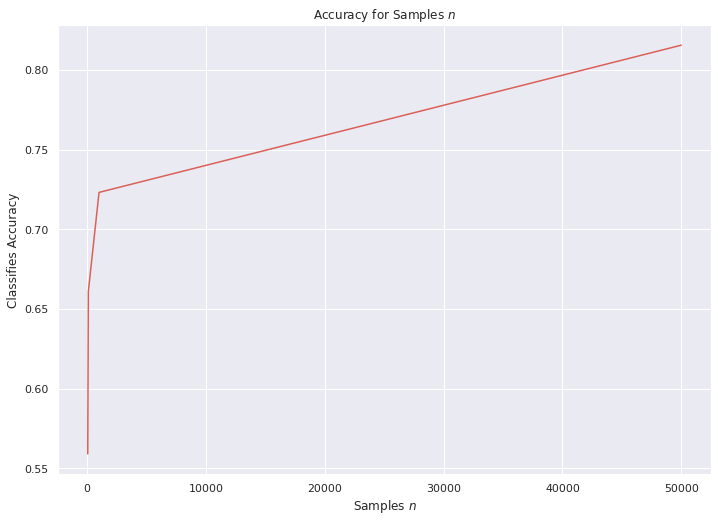

In [0]:
sns.lineplot(sizes, [scores[s] for s in sizes])

plt.xlabel('Samples $n$')
plt.ylabel('Classifies Accuracy')

plt.title('Accuracy for Samples $n$')

plt.show()